In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Creating a simple data range

data = tf.data.Dataset.range(10)
for val in data:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [15]:
# Using window with a size of 5 and shift of 5

data = tf.data.Dataset.range(10)
data = tf.data.Dataset.window(data,size=5,shift=1)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(),end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [16]:
# Drop the remainder

data = tf.data.Dataset.range(10)
data = tf.data.Dataset.window(data,size=5,shift=1,drop_remainder=True)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(),end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [23]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))

for window in data:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [25]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
for x, y in data:
    print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [26]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
data = data.shuffle(buffer_size=10)
for x, y in data:
    print(x.numpy(),y.numpy())

[5 6 7 8] [9]
[2 3 4 5] [6]
[0 1 2 3] [4]
[1 2 3 4] [5]
[4 5 6 7] [8]
[3 4 5 6] [7]


In [28]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
data = data.shuffle(buffer_size=10)
data = data.batch(2).prefetch(1)
for x, y in data:
    print("x = ", x.numpy())
    print("y = ", y.numpy())


x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[0 1 2 3]
 [3 4 5 6]]
y =  [[4]
 [7]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]


In [52]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Single Layer Neural Network

In [53]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [54]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [55]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03676178],
       [-0.03965135],
       [ 0.06573425],
       [ 0.02663448],
       [-0.0553091 ],
       [ 0.00843279],
       [ 0.05383448],
       [ 0.08286249],
       [-0.10234562],
       [-0.07253668],
       [ 0.05909813],
       [ 0.00914905],
       [-0.02188684],
       [ 0.06037338],
       [-0.05200404],
       [ 0.14915454],
       [ 0.00488418],
       [ 0.11103487],
       [ 0.26416364],
       [ 0.48424602]], dtype=float32), array([0.01683432], dtype=float32)]


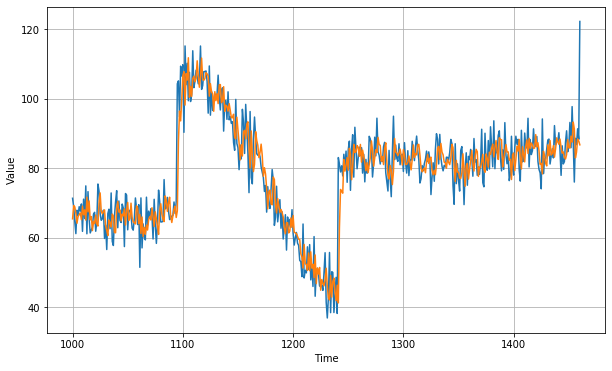

In [56]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [57]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1018414

### Deep Neural Network

In [59]:
model = tf.keras.models.Sequential([
                        tf.keras.layers.Dense(10, input_shape=[window_size],activation='relu'),
                        tf.keras.layers.Dense(10, activation="relu"),
                        tf.keras.layers.Dense(1)])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03676178],
       [-0.03965135],
       [ 0.06573425],
       [ 0.02663448],
       [-0.0553091 ],
       [ 0.00843279],
       [ 0.05383448],
       [ 0.08286249],
       [-0.10234562],
       [-0.07253668],
       [ 0.05909813],
       [ 0.00914905],
       [-0.02188684],
       [ 0.06037338],
       [-0.05200404],
       [ 0.14915454],
       [ 0.00488418],
       [ 0.11103487],
       [ 0.26416364],
       [ 0.48424602]], dtype=float32), array([0.01683432], dtype=float32)]


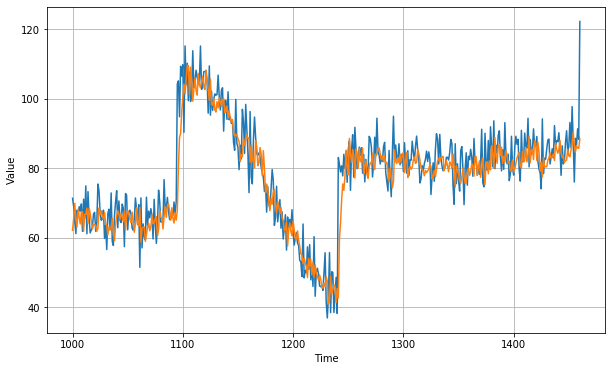

In [60]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0504427

### Scheduling the Learning Rate using callbacks

In [62]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

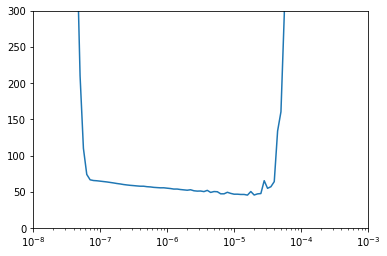

In [63]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

### Training on optimum learning rate and increased number of epochs

In [64]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

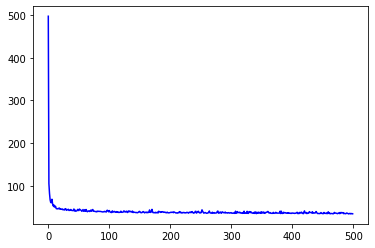

In [65]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[50.00450480352972, 52.46731016807949, 51.348611119850396, 46.38174192684213, 46.00564546486766, 45.79406087816376, 46.66092323224569, 46.15727612996839, 47.84253034689992, 45.227289754336645, 46.32885206556812, 45.086621424094915, 44.66135639308654, 45.5914788786898, 43.61543993605781, 43.91469296720839, 44.66288182366755, 43.17880777575306, 46.27278952844364, 45.48781468106299, 42.38184079042415, 43.38986344484939, 44.328500177442415, 44.74700071983731, 42.08059820588102, 42.47081444337196, 42.479306116792344, 44.40666621886578, 42.43350686142125, 41.95307509432134, 41.91819316431419, 41.787167964030786, 45.49456949135692, 40.85621422836461, 42.878939776076486, 40.48132113820499, 40.7647159930357, 41.24645347988483, 44.45067295585711, 44.03829667396152, 41.70652139014805, 45.385476558724626, 44.27129824923486, 43.34768010562228, 42.07881534222475, 40.071726093095606, 42.04816409238835, 44.207510391707274, 40.08044045831739, 40.88246789912588, 43.981331292378535, 40.10726265661495, 44

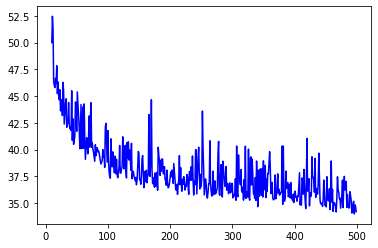

In [66]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

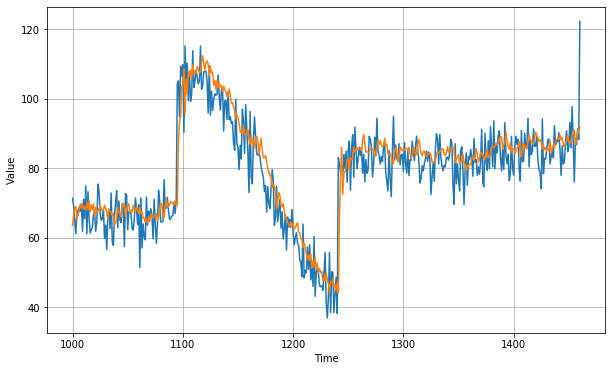

In [67]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [68]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1416645